In [ ]:
!pip install torch accelerate einops plotly

In [39]:
%matplotlib inline

import torch as t
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from torch_optimizers import SGD, Adam, RMSprop

In [ ]:
batch_size = 32

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=ToTensor())
test_dataset = datasets.MNIST('./data', train=False, transform=ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# For training with the MLP we will need to resize the input image to a vector

for (data, target) in train_loader:
    print('data:', data.size(), 'type:', data.type())
    print('target:', target.size(), 'type:', target.type())
    break

data: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
target: torch.Size([32]) type: torch.LongTensor


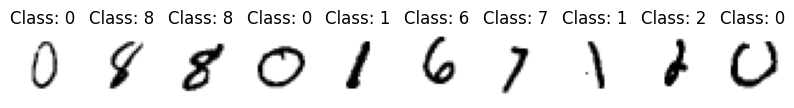

In [7]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(data[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(target[i].item()))

### Simple MLP

In [66]:
class MLP(nn.Module):

    def __init__(self, input_dim, hd1, num_classes):
        super().__init__()

        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(input_dim, hd1)
        self.fc2 = nn.Linear(hd1, num_classes)

    def forward(self, x):

        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

In [111]:
device = t.device("cuda")

model = MLP(28*28, 128, 10)
model = model.to(device)

input = t.rand(1, 28, 28, device=device)
output = model(input)

print("Output Shape: ", output.shape)

Output Shape:  torch.Size([1, 10])


In [112]:
y_pred = output.argmax(dim=1)

print(y_pred)

tensor([4], device='cuda:0')


In [113]:
SGD_optim = SGD(model.parameters(), lr=2e-3, momentum=0.99)
criterion = nn.CrossEntropyLoss()

In [114]:
num_batches = len(train_loader)
num_items = len(train_loader.dataset)

print("Num Batches: ", num_batches)
print("Num Items: ", num_items)

Num Batches:  1875
Num Items:  60000


In [115]:
def train(optimizer):
    model.train()

    total_loss = 0
    total_correct = 0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        output = model(x)
        y_pred = output.argmax(dim=1)

        # Calculate the loss and backprop
        loss = criterion(output, y)
        total_loss += loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        num_correct = (y_pred == y).bool().sum()
        total_correct += num_correct.item()

    train_loss = total_loss/num_batches
    accuracy = total_correct/num_items
    print(f"Average loss: {train_loss:7f}, accuracy: {accuracy:.2%}")

    return train_loss.detach().item()

In [116]:
%%time
epochs = 10
sgd_loss_values = []

for epoch in range(epochs):
    print(f"Training epoch: {epoch+1}")
    epoch_loss = train(SGD_optim)
    sgd_loss_values.append(epoch_loss)

Training epoch: 1
Average loss: 0.375327, accuracy: 89.53%
Training epoch: 2
Average loss: 0.130427, accuracy: 96.19%
Training epoch: 3
Average loss: 0.089649, accuracy: 97.33%
Training epoch: 4
Average loss: 0.067820, accuracy: 97.89%
Training epoch: 5
Average loss: 0.055576, accuracy: 98.28%
Training epoch: 6
Average loss: 0.043798, accuracy: 98.63%
Training epoch: 7
Average loss: 0.034945, accuracy: 98.93%
Training epoch: 8
Average loss: 0.029166, accuracy: 99.12%
Training epoch: 9
Average loss: 0.025418, accuracy: 99.22%
Training epoch: 10
Average loss: 0.020798, accuracy: 99.42%
CPU times: user 1min 28s, sys: 737 ms, total: 1min 29s
Wall time: 1min 31s


#### Adam

In [118]:
device = t.device("cuda")

model = MLP(28*28, 128, 10)
model = model.to(device)

input = t.rand(1, 28, 28, device=device)
output = model(input)

print("Output Shape: ", output.shape)

Output Shape:  torch.Size([1, 10])


In [119]:
Adam_optim = Adam(model.parameters(), lr=2e-3, beta1= 0.9, beta2= 0.99)
criterion = nn.CrossEntropyLoss()

In [120]:
%%time
epochs = 10
adam_loss_values = []

for epoch in range(epochs):
    print(f"Training epoch: {epoch+1}")
    epoch_loss = train(Adam_optim)
    adam_loss_values.append(epoch_loss)

Training epoch: 1
Average loss: 0.238595, accuracy: 92.98%
Training epoch: 2
Average loss: 0.100643, accuracy: 96.93%
Training epoch: 3
Average loss: 0.072457, accuracy: 97.74%
Training epoch: 4
Average loss: 0.055049, accuracy: 98.26%
Training epoch: 5
Average loss: 0.045976, accuracy: 98.53%
Training epoch: 6
Average loss: 0.037575, accuracy: 98.79%
Training epoch: 7
Average loss: 0.033008, accuracy: 98.86%
Training epoch: 8
Average loss: 0.026180, accuracy: 99.15%
Training epoch: 9
Average loss: 0.023334, accuracy: 99.24%
Training epoch: 10
Average loss: 0.020935, accuracy: 99.28%
CPU times: user 1min 36s, sys: 767 ms, total: 1min 37s
Wall time: 1min 38s


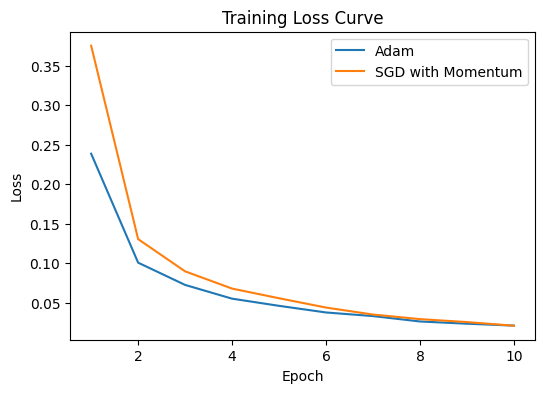

In [121]:
plt.figure(figsize=(6, 4))

plt.plot(range(1, epochs+1), adam_loss_values, label="Adam")
plt.plot(range(1, epochs+1), sgd_loss_values, label="SGD with Momentum")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()